In [1]:
import geoengine as ge
from typing import List, Tuple
import asyncio
from aiostream import stream
import xarray as xr

In [2]:
client_1 = ge.create_client("http://localhost:3030/api")
client_1.get_session()


Server:              http://localhost:3030/api
User Id:             27f6a0a4-0bf1-4010-8b9a-1c358b1b3ec5
Session Id:          fbff0be0-58b6-478c-aaa4-61aa9f0816e3
Session valid until: 2023-11-26T10:47:54.867Z

In [3]:
client_2 = ge.create_client("https://internal-nightly.peter.geoengine.io/api")
client_2.get_session()

Server:              https://internal-nightly.peter.geoengine.io/api
User Id:             c3014fee-c109-47cc-bcff-4aef5e7a3c1b
Session Id:          6cdac1ff-8f3f-46eb-ade4-3c216ffdcd4c
Session valid until: 2023-11-26T10:47:54.925Z

In [4]:
def get_raster_dataset_workflow_by_name(dataset_name: str, client: ge.Client) -> ge.Workflow:
    op = ge.workflow_builder.operators.GdalSource(dataset=dataset_name)
    return client.register_workflow(op)



In [5]:
client_1_wfl = get_raster_dataset_workflow_by_name("modis-evi", client_1)
client_1_wfl

d59770c5-7965-52cc-9e23-0c0cd4dda369

In [6]:
client_2_wfl = get_raster_dataset_workflow_by_name("modis-evi", client_2)
client_2_wfl

d59770c5-7965-52cc-9e23-0c0cd4dda369

In [7]:
time = "2014-01-01T00:00:00.000Z"
query_rect = ge.QueryRectangle(
                ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
                ge.TimeInterval(time, time),
                resolution=ge.SpatialResolution(0.1, 0.1),
            )

query_rect

QueryRectangle( 
    BoundingBox2D(xmin=-180.0, ymin=-90.0, xmax=180.0, ymax=90.0)
    TimeInterval(start=2014-01-01T00:00:00.000000, end=2014-01-01T00:00:00.000000)
    SpatialResolution(x=0.1, y=0.1)
    srs=EPSG:4326 
)

In [8]:
def split_query_rect_in_two(query_rect: ge.QueryRectangle) -> Tuple[ge.QueryRectangle, ge.QueryRectangle]:
    qr_widht = query_rect.spatial_bounds.x_axis_size()
    qr_height = query_rect.spatial_bounds.y_axis_size()
    qr_half_width = qr_widht / 2
    x_min = query_rect.spatial_bounds.xmin
    y_min = query_rect.spatial_bounds.ymin
    x_max = query_rect.spatial_bounds.xmax
    y_max = query_rect.spatial_bounds.ymax

    qr_1 = ge.QueryRectangle(
        ge.BoundingBox2D(x_min, y_min, x_min + qr_half_width, y_max),
        query_rect.time,
        query_rect.spatial_resolution,
    )

    qr_2 = ge.QueryRectangle(
        ge.BoundingBox2D(x_min + qr_half_width, y_min, x_max, y_max),
        query_rect.time,
        query_rect.spatial_resolution,
    )

    return (qr_1, qr_2)

(query_rect_1, query_rect_2) = split_query_rect_in_two(query_rect)

query_rect_1, query_rect_2

(QueryRectangle( 
     BoundingBox2D(xmin=-180.0, ymin=-90.0, xmax=0.0, ymax=90.0)
     TimeInterval(start=2014-01-01T00:00:00.000000, end=2014-01-01T00:00:00.000000)
     SpatialResolution(x=0.1, y=0.1)
     srs=EPSG:4326 
 ),
 QueryRectangle( 
     BoundingBox2D(xmin=0.0, ymin=-90.0, xmax=180.0, ymax=90.0)
     TimeInterval(start=2014-01-01T00:00:00.000000, end=2014-01-01T00:00:00.000000)
     SpatialResolution(x=0.1, y=0.1)
     srs=EPSG:4326 
 ))

Connecting to ws://localhost:3030/api/workflow/d59770c5-7965-52cc-9e23-0c0cd4dda369/rasterStream?resultType=arrow&spatialBounds=-180.0%2C-90.0%2C0.0%2C90.0&timeInterval=2014-01-01T00%3A00%3A00.000%2B00%3A00&spatialResolution=0.1%2C0.1
Connecting to wss://internal-nightly.peter.geoengine.io/api/workflow/d59770c5-7965-52cc-9e23-0c0cd4dda369/rasterStream?resultType=arrow&spatialBounds=0.0%2C-90.0%2C180.0%2C90.0&timeInterval=2014-01-01T00%3A00%3A00.000%2B00%3A00&spatialResolution=0.1%2C0.1
32
<xarray.DataArray (y: 2048, x: 4096)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -204.8 -204.7 -204.6 -204.5 ... 204.5 204.6 204.7
  * y            (y) float64 102.4 102.3 102.2 102.1 ... -102.2 -102.3 -102.4
    time         date

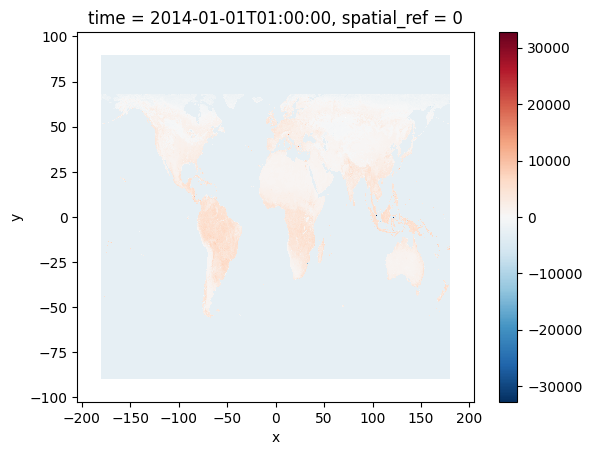

In [9]:


query_client_1 = client_1_wfl.raster_stream(query_rect_1)
query_client_2 = client_2_wfl.raster_stream(query_rect_2)

merged_query = stream.merge(query_client_1, query_client_2)

async with merged_query.stream() as streamer:
    tiles  = [tile.to_xarray() async for tile in streamer]
    print(len(tiles))
    combined_tiles = xr.combine_by_coords(tiles)

    print(combined_tiles)
    combined_tiles.plot()





